# Line detection

This notebook is used to demonstrate a way to automatically detect the 2 horizontals lines for KH-9 PC images after joining all parts.
This is still experimental an need a lot of improvement.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rasterio
from rasterio.windows import Window
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.signal import find_peaks

from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
path1 = "/home/godinlu/Documents/github/ship/hipp/notebooks/data/kh9pc/joined_images/D3C1214-100097A014.tif"
path2 = "/home/godinlu/Documents/github/ship/hipp/notebooks/data/kh9pc/joined_images/D3C1214-100097A015.tif"

## extracting upper and lower band profiles

The first step is to reconstruct the upper and lower horizontal bands of the image.
This is done by splitting the raster into vertical blocks of size bloc_width pixels and computing a statistical profile (mean, median, or another reducer) across each block.

This horizontal compression reduces noise by averaging neighboring pixels and significantly decreases the data volume, which improves both robustness and computing efficiency.

In [4]:
def detect_upper_band_profiles(file: str, bloc_width: int = 255, padding: int = 700, window_height: int = 1500):
    """Extract vertical profiles from a horizontal band located near the TOP of the image."""
    profiles = []

    with rasterio.open(file) as src:
        row_off = padding  # band near the top
        for col_off in tqdm(range(0, src.width, bloc_width)):
            window = Window(col_off=col_off, row_off=row_off, width=bloc_width, height=window_height)
            subset = src.read(1, window=window)
            median_subset = np.ma.median(subset, axis=1).filled(np.nan)
            profiles.append(median_subset)

    return np.stack(profiles, axis=1), row_off


def detect_lower_band_profiles(file: str, bloc_width: int = 255, padding: int = 700, window_height: int = 1500):
    """Extract vertical profiles from a horizontal band located near the BOTTOM of the image."""
    profiles = []

    with rasterio.open(file) as src:
        row_off = src.height - padding - window_height  # band near the bottom
        for col_off in tqdm(range(0, src.width, bloc_width)):
            window = Window(col_off=col_off, row_off=row_off, width=bloc_width, height=window_height)
            subset = src.read(1, window=window)
            median_subset = np.ma.mean(subset, axis=1).filled(np.nan)
            profiles.append(median_subset)

    return np.stack(profiles, axis=1), row_off

## Examples

100%|██████████| 1409/1409 [00:04<00:00, 285.76it/s]


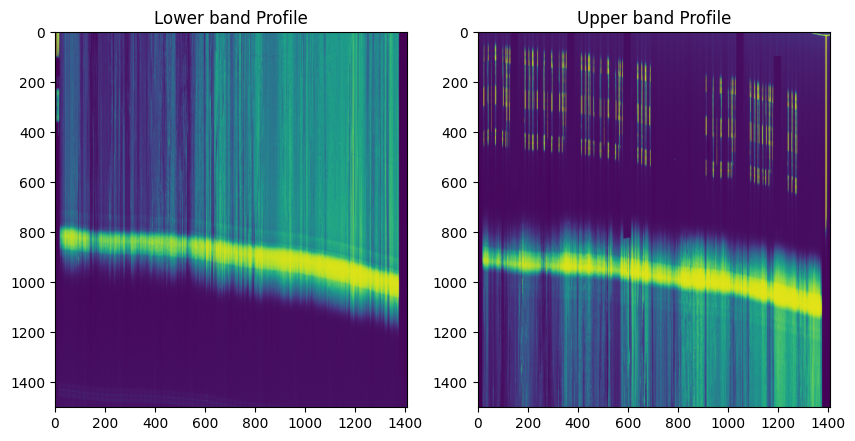

In [5]:
block_width = 255
lower_band_profile, lower_y_offset = detect_lower_band_profiles(path1, block_width)
upper_band_profile, upper_y_offset = detect_upper_band_profiles(path1, block_width)

fig, axes = plt.subplots(1, 2, figsize=(10,8))
axes[0].imshow(lower_band_profile)
axes[0].set_title("Lower band Profile")

axes[1].imshow(upper_band_profile)
axes[1].set_title("Upper band Profile")
plt.show()

## Detecting lines using light peaks

By scanning the intensity profiles column by column, we can detect the **vertical position (y)** of bright peaks that correspond to horizontal lines in the image. This relies on the `scipy.signal.find_peaks` function, where a few carefully chosen parameters help isolate the relevant structures:

- `distance` : set to **200** to ensure that only well-separated peaks are detected, avoiding multiple detections of the same line.  
- `prominence` : set to **50** so that only peaks that strongly stand out from their surrounding signal are considered as valid lines.  
- `height` : set to **150** since the line is bright and close to white values in the image.  
- `width` : set to **50** because the physical thickness of the line in the image is approximately 50 pixels.  

These parameters may need to be tuned depending on the specific image contrast, resolution, and noise level.


In [6]:
def detect_peaks_in_columns(median_image: np.ndarray,
                            distance: int = 200,
                            prominence: float = 50,
                            height: float = 150,
                            width: float = 50):
    peaks_x, peaks_y = [], []
    n_cols = median_image.shape[1]

    for col in range(n_cols):
        signal = median_image[:, col]

        # Trouver les pics sur cette colonne
        pks, _ = find_peaks(signal, distance=distance,
                            prominence=prominence, height=height, width=width)

        for y in pks:
            peaks_x.append(col)
            peaks_y.append(y)

    return np.array(peaks_x), np.array(peaks_y)

## Example

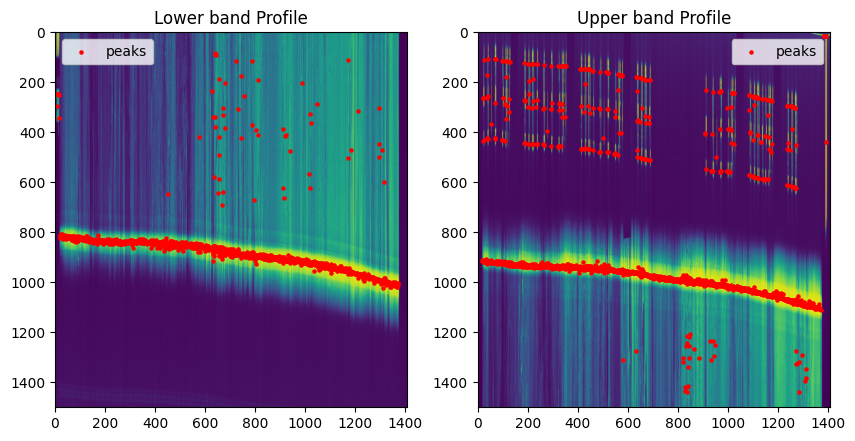

In [7]:
upper_x, upper_y = detect_peaks_in_columns(upper_band_profile)
lower_x, lower_y = detect_peaks_in_columns(lower_band_profile)

fig, axes = plt.subplots(1, 2, figsize=(10,8))
axes[0].imshow(lower_band_profile)
axes[0].scatter(lower_x, lower_y, color="red", s=5, label="peaks")
axes[0].set_title("Lower band Profile")
axes[0].legend()

axes[1].imshow(upper_band_profile)
axes[1].scatter(upper_x, upper_y, color="red", s=5, label="peaks")
axes[1].set_title("Upper band Profile")
axes[1].legend()
plt.show()

## Fit a RANSAC polynomial function over the peaks 

In [8]:
def polynomial_ransac(x, y, degree: int = 2, residual_threshold: float = 50.0, min_samples: int = 3, max_trials: int = 1000) -> RANSACRegressor:
    X = x.reshape(-1, 1)

    base_model = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        LinearRegression()
    )
    ransac = RANSACRegressor(base_model, residual_threshold=residual_threshold, min_samples=min_samples, random_state=0, max_trials=max_trials)
    ransac.fit(X, y)
    return ransac

def linear_ransac(x, y, residual_threshold: float = 50.0, min_samples: int = 2) -> RANSACRegressor:
    X = x.reshape(-1, 1)
    base_model = LinearRegression()

    ransac = RANSACRegressor(
        base_model,
        residual_threshold=residual_threshold,
        min_samples=min_samples,
        random_state=0
    )
    ransac.fit(X, y)
    return ransac

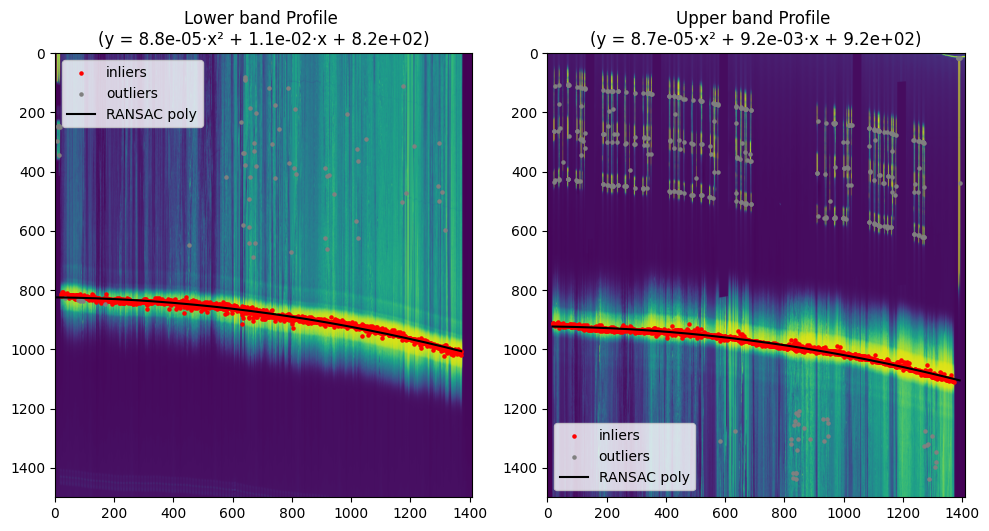

In [9]:
def get_poly_equation(ransac):
    """Return polynomial equation as a string for plot titles."""
    linreg = ransac.estimator_.named_steps["linearregression"]
    a, b = linreg.coef_[1], linreg.coef_[0]
    c = linreg.intercept_
    return f"y = {a:.1e}·x² + {b:.1e}·x + {c:.1e}"

upper_ransac = polynomial_ransac(upper_x, upper_y)
lower_ransac = polynomial_ransac(lower_x, lower_y)

upper_y_fit = upper_ransac.predict(upper_x.reshape(-1, 1))
lower_y_fit = lower_ransac.predict(lower_x.reshape(-1, 1))

upper_inlier_mask = upper_ransac.inlier_mask_        
lower_inlier_mask = lower_ransac.inlier_mask_        

fig, axes = plt.subplots(1, 2, figsize=(10,8))
axes[0].imshow(lower_band_profile)
axes[0].scatter(lower_x[lower_inlier_mask], lower_y[lower_inlier_mask], color="red", s=5, label="inliers")
axes[0].scatter(lower_x[~lower_inlier_mask], lower_y[~lower_inlier_mask], color="gray", s=5, label="outliers")
axes[0].plot(lower_x, lower_y_fit, color="black", label="RANSAC poly")
axes[0].set_title(f"Lower band Profile \n({get_poly_equation(lower_ransac)})")
axes[0].legend()

axes[1].imshow(upper_band_profile)
axes[1].scatter(upper_x[upper_inlier_mask], upper_y[upper_inlier_mask], color="red", s=5, label="inliers")
axes[1].scatter(upper_x[~upper_inlier_mask], upper_y[~upper_inlier_mask], color="gray", s=5, label="outliers")
axes[1].plot(upper_x, upper_y_fit, color="black", label="RANSAC poly")
axes[1].set_title(f"Upper band Profile \n({get_poly_equation(upper_ransac)})")
axes[1].legend()
plt.tight_layout()
plt.show()


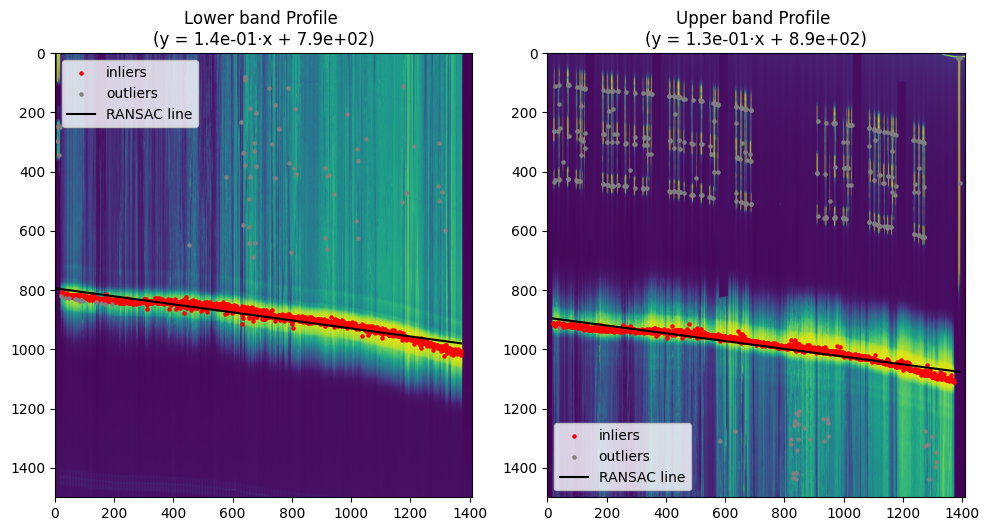

In [10]:
def get_linear_equation(ransac):
    """Return linear equation as a string for plot titles."""
    linreg = ransac.estimator_
    a = linreg.coef_[0]
    b = linreg.intercept_
    return f"y = {a:.1e}·x + {b:.1e}"

upper_ransac = linear_ransac(upper_x, upper_y)
lower_ransac = linear_ransac(lower_x, lower_y)

upper_y_fit = upper_ransac.predict(upper_x.reshape(-1, 1))
lower_y_fit = lower_ransac.predict(lower_x.reshape(-1, 1))

upper_inlier_mask = upper_ransac.inlier_mask_        
lower_inlier_mask = lower_ransac.inlier_mask_        

fig, axes = plt.subplots(1, 2, figsize=(10,8))
axes[0].imshow(lower_band_profile)
axes[0].scatter(lower_x[lower_inlier_mask], lower_y[lower_inlier_mask], color="red", s=5, label="inliers")
axes[0].scatter(lower_x[~lower_inlier_mask], lower_y[~lower_inlier_mask], color="gray", s=5, label="outliers")
axes[0].plot(lower_x, lower_y_fit, color="black", label="RANSAC line")
axes[0].set_title(f"Lower band Profile \n({get_linear_equation(lower_ransac)})")
axes[0].legend()

axes[1].imshow(upper_band_profile)
axes[1].scatter(upper_x[upper_inlier_mask], upper_y[upper_inlier_mask], color="red", s=5, label="inliers")
axes[1].scatter(upper_x[~upper_inlier_mask], upper_y[~upper_inlier_mask], color="gray", s=5, label="outliers")
axes[1].plot(upper_x, upper_y_fit, color="black", label="RANSAC line")
axes[1].set_title(f"Upper band Profile \n({get_linear_equation(upper_ransac)})")
axes[1].legend()
plt.tight_layout()
plt.show()

## Plot lines on the image

First step transform coordinate into the globale image reference

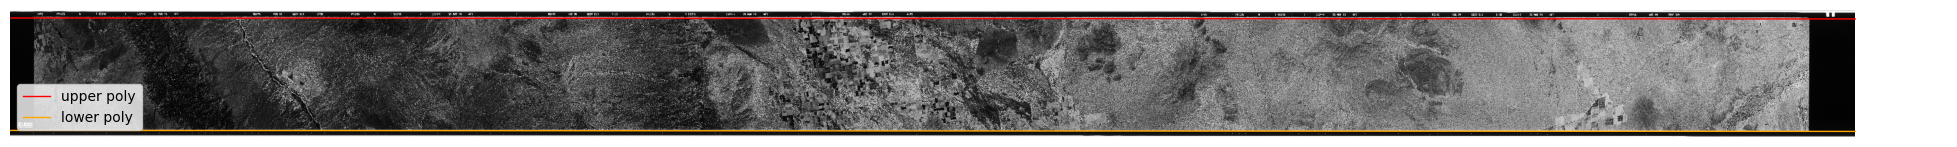

In [11]:
downscale_factor = 100

with rasterio.open(path1) as src:
    # Calculate new shape
    new_height = src.height // downscale_factor
    new_width = src.width // downscale_factor

    # Read with resampling
    downscaled_img = src.read(
        1,
        out_shape=(new_height, new_width),
        resampling=Resampling.nearest
    )
    # X in the image reference
    img_x = np.linspace(0, src.width, 1000)

    
    # transform X for matching with the ransac training reference 
    img_x_train = img_x / block_width  
global_upper_y = upper_ransac.predict(img_x_train.reshape(-1, 1)) + upper_y_offset
global_lower_y = lower_ransac.predict(img_x_train.reshape(-1, 1)) + lower_y_offset


# Plot
plt.figure(figsize=(25, 12))
plt.imshow(downscaled_img, cmap="gray")
plt.plot(img_x / downscale_factor, global_upper_y / downscale_factor, color="red", lw=1, label="upper poly")
plt.plot(img_x / downscale_factor, global_lower_y / downscale_factor, color="orange", lw=1, label="lower poly")
plt.axis("off")
plt.legend()
plt.show()